In [ ]:

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_capability())

In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/IDA.zip" /content/

In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/benthic/loadbm.py" /content/

In [ ]:
%%capture
!unzip IDA.zip

In [ ]:
import numpy as np
import os
import ntpath
import platform
import matplotlib.pyplot as plt
from loadbm import create_df, create_tf_dataset, prepare_for_training


datapath = 'IDA/Separate lists with numbering/Machine learning splits'
img_path = 'IDA/Images/'

split = 1

train_fname = 'train'+str(split)+'.txt'
test_fname = 'test'+str(split)+'.txt'
val_fname = 'val'+str(split)+'.txt'

part_dat = False

df_train = create_df(os.path.join(datapath, train_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

df_test = create_df(os.path.join(datapath, test_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

df_val = create_df(os.path.join(datapath, val_fname),
                     img_path,
                     partial_dataset=part_dat,
                     seed=123)

from sklearn.utils import shuffle

df_train = shuffle(df_train)
df_val = shuffle(df_val)

df_train.head()

,path,label
203178,IDA/Images/Micrasema_set103/0-Micrasema_set103...,24
230157,IDA/Images/Neureclipsis_bim372/1-Neureclipsis_...,27
108337,IDA/Images/Heptagenia_sul8/0-Heptagenia_sul8.1...,11
266436,IDA/Images/Polycentropus_irr3/1-Polycentropus_...,32
220856,IDA/Images/Neureclipsis_bim140/1-Neureclipsis_...,27


Text(0.5, 1.0, 'pre-sampling')

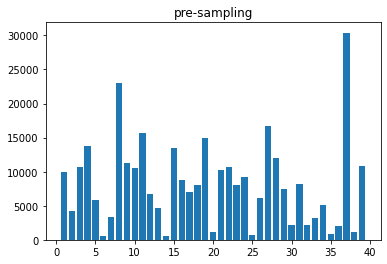

In [ ]:
h = np.histogram(df_train['label'],bins=39)[0]
plt.bar(range(1,40), h)
plt.title('pre-sampling')

In [ ]:
import pandas as pd
def calc_sampling(df, method='mean'):
    h = np.histogram(df['label'],bins=39)[0]
    if method=='mean':
      a = np.mean(h).astype(int)
    elif method=='max':
      a = np.max(h).astype(int)

    delta = a-h
    delta[delta <0] = 0

    return delta

delta = calc_sampling(df_train)


def oversample_df(df, delta):
    lst = [df]
    for i, group in df.groupby('label'):
        lst.append(group.sample(delta[i-1], replace=True))
        
    return pd.concat(lst)

Duplicate samples: 92018.
 Percentage: 0.222574832194473


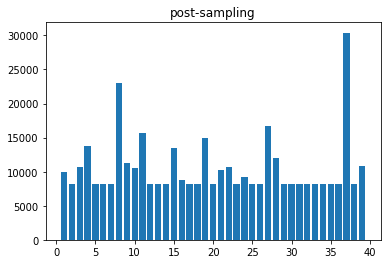

In [ ]:
df_train_new = oversample_df(df_train, 
                         calc_sampling(df_train, method='mean'))

h_new = np.histogram(df_train_new['label'],bins=39)[0]
plt.bar(range(1,40), h_new)
plt.title('post-sampling')
dup_amount = len(df_train_new)-len(df_train)
print('Duplicate samples: {}.\n Percentage: {}'.format(dup_amount,
                                                       dup_amount/len(df_train_new)))
df_train = df_train_new.copy()

In [ ]:
# Data augmentation
def train_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMSIZE = (224,224,3)
BATCH_SIZE = 32

train_ds = create_tf_dataset(df_train, imsize=IMSIZE, onehot=True)

val_ds = create_tf_dataset(df_val, imsize=IMSIZE, onehot=True)


train_ds = prepare_for_training(train_ds, 
                                shuffle_buffer_size=1000,
                                batch_size=BATCH_SIZE)

val_ds = prepare_for_training(val_ds, 
                              shuffle_buffer_size=1000,
                              batch_size=BATCH_SIZE)


# augmentation
train_ds.map(train_augment, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(5):
    print(image.shape)
    print(label.shape)


(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)
(32, 224, 224, 3)
(32, 39)


In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/18-01-2020_cont_colab.h5" /content/

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('18-01-2020_cont_colab.h5')

In [ ]:
for layer in model.layers:
  layer.trainable = False

for layer in model.layers[-3:]:
  layer.trainable = True

for layer in model.layers[-5:]:
  print(layer)
  print(layer.trainable)

False
False
True
True
True


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
import datetime

tr_steps = len(df_train)//BATCH_SIZE
val_steps = len(df_val)//BATCH_SIZE

model.fit(train_ds, 
          validation_data= val_ds, 
          steps_per_epoch= tr_steps, 
          epochs = 20,
          validation_steps = val_steps)


Train for 12919 steps, validate for 1434 steps
Epoch 1/20
12919/12919 [==============================] - 832s 64ms/step - loss: 0.8504 - accuracy: 0.8818 - val_loss: 1.9355 - val_accuracy: 0.7304
Epoch 2/20
12919/12919 [==============================] - 816s 63ms/step - loss: 0.4347 - accuracy: 0.9058 - val_loss: 2.7405 - val_accuracy: 0.7206
Epoch 3/20
12919/12919 [==============================] - 817s 63ms/step - loss: 0.3262 - accuracy: 0.9270 - val_loss: 3.0612 - val_accuracy: 0.7400
Epoch 4/20
12919/12919 [==============================] - 817s 63ms/step - loss: 0.2576 - accuracy: 0.9407 - val_loss: 2.4559 - val_accuracy: 0.7708
Epoch 5/20
 5680/12919 [============>.................] - ETA: 6:48 - loss: 0.0128 - accuracy: 0.9973Buffered data was truncated after reaching the output size limit.

In [ ]:
model.save('29-02-2020_cont_colab.h5')

In [ ]:
!cp '29-02-2020_cont_colab.h5' "/content/drive/My Drive/koulu_honmia/kandi19/"

Evaluation:

In [ ]:
test_ds = create_tf_dataset(df_test, imsize=IMSIZE, onehot=True)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
!cp "/content/drive/My Drive/koulu_honmia/kandi19/benthic/combine_insects.py" /content/

In [ ]:
preds = model.predict(test_ds, verbose=True)
yhat = np.argmax(preds,axis=1)+1
y_test = df_test['label']

acc = np.sum(yhat==y_test)/len(y_test)
print('Image accuracy: {:.4f}'.format(acc))

2897/2897 [==============================] - 152s 52ms/step
Image accuracy: 0.8673


In [ ]:
#%% Insect combine
from combine_insects import add_insect_class, add_yhat

df_test_preds = add_insect_class(df_test)

# adding predictions to dataframe for insect-wise prediction
df_test_preds = add_yhat(df_test_preds,yhat)

dfg = df_test_preds.groupby(['label','insect'],as_index=False)['pred'].agg(lambda x:x.value_counts().index[0])

acc_g = np.sum(dfg['pred']==dfg['label'])/len(dfg)
print('Aggregate accuracy: {:.4f}'.format(acc_g))

Aggregate accuracy: 0.9181


In [ ]:
np.save('29-02-2020_cont_colab.npy', preds)

In [ ]:
!cp '29-02-2020_cont_colab.npy' "/content/drive/My Drive/koulu_honmia/kandi19/"